In [1]:

import os
from pathlib import Path

import torch
from dotenv import load_dotenv
from loguru import logger
from qdrant_client import QdrantClient
from qdrant_client.http import models
from transformers import ViTImageProcessor, ViTModel

In [2]:
load_dotenv()
QDRANT_URL = os.environ.get("QDRANT_URL")
QDRANT_API_KEY = os.environ.get("QDRANT_API_KEY")
MODEL_NAME = 'facebook/dino-vits16'
DATA_DIR = Path("data/photos")

In [3]:
client = QdrantClient(
    url=QDRANT_URL,
    api_key=QDRANT_API_KEY,
)
my_collection = "image_collection"

In [4]:
if client.get_collection(collection_name=my_collection):
    logger.info("Collection already exists. Skip creating.")
else:
    logger.info(f"Creating collection {my_collection}")
    client.create_collection(
        collection_name=my_collection,
        vectors_config=models.VectorParams(size=384, distance=models.Distance.COSINE)
    )

2024-05-12 16:01:39.880 | INFO     | __main__:<module>:2 - Collection already exists. Skip creating.


In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
model = ViTModel.from_pretrained(MODEL_NAME).to(device)
logger.info(f"Device used: {device}")
logger.info(f"Model loaded: {MODEL_NAME}")

/Users/graziano/Documents/GitHub/face-detector-fast-api/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2024-05-12 16:01:40.997 | INFO     | __main__:<module>:4 - Device used: mps
2024-05-12 16:01:40.998 | INFO     | __main__:<module>:5 - Model loaded: facebook/dino-vits16


In [6]:
images = list(DATA_DIR.rglob("*.jpg"))[:200]

In [7]:
import polars as pl
from PIL import Image
from p_tqdm import p_umap
from copy import deepcopy

image_file = []
image_name = []

logger.info("Loading images")


def load_image(file):
    img_file = Image.open(file)
    img_copy = deepcopy(img_file)  # Workaround for OSError
    img_file.close()
    return str(file).split(".")[0], img_copy


image_names, image_files = zip(*p_umap(load_image, images))

df = pl.DataFrame({"Image": image_files, "Name": image_names})

2024-05-12 16:01:41.425 | INFO     | __main__:<module>:9 - Loading images


  0%|          | 0/200 [00:00<?, ?it/s]

In [8]:
def get_embeddings_from_image(item):
    inputs = processor(images=item, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs).last_hidden_state.mean(dim=1).cpu().numpy()
    return outputs

embeddings = []
for item in df['Image']:
    embeddings.append(get_embeddings_from_image(item))

In [9]:
payload = []
for i, name in enumerate(df['Name']):
    payload.append({"image_id": i,
                    "name": name})


In [10]:
for i in range(0, df.shape[0]):
    client.upsert(
        collection_name=my_collection,
        points=models.Batch(
            ids=[i],
            vectors=embeddings[i],
            payloads=[payload[i]]
        )
    )

#check if the update is successful
client.count(
    collection_name=my_collection,
    exact=True,
)
#To visually inspect the collection we just created, we can scroll through our vectors with the client.scroll() method.
client.scroll(
    collection_name=my_collection,
    limit=10
)

([Record(id=0, payload={'image_id': 0, 'name': 'data/photos/Sureyya_Ayhan/Sureyya_Ayhan_0001'}, vector=None, shard_key=None),
  Record(id=1, payload={'image_id': 1, 'name': 'data/photos/Dragan_Covic/Dragan_Covic_0001'}, vector=None, shard_key=None),
  Record(id=2, payload={'image_id': 2, 'name': 'data/photos/Jeff_Hornacek/Jeff_Hornacek_0001'}, vector=None, shard_key=None),
  Record(id=3, payload={'image_id': 3, 'name': 'data/photos/German_Khan/German_Khan_0001'}, vector=None, shard_key=None),
  Record(id=4, payload={'image_id': 4, 'name': 'data/photos/Stefano_Gabbana/Stefano_Gabbana_0001'}, vector=None, shard_key=None),
  Record(id=5, payload={'image_id': 5, 'name': 'data/photos/Deb_Santos/Deb_Santos_0001'}, vector=None, shard_key=None),
  Record(id=6, payload={'image_id': 6, 'name': 'data/photos/Bob_Newhart/Bob_Newhart_0001'}, vector=None, shard_key=None),
  Record(id=7, payload={'image_id': 7, 'name': 'data/photos/Paul_McNulty/Paul_McNulty_0002'}, vector=None, shard_key=None),
  Reco

In [11]:
def see_images(results, top_k=2):
    for i in range(top_k):
        image_id = results[i].payload['image_id']
        name = results[i].payload['name']
        score = results[i].score
        image = Image.open(images[image_id])

        logger.info(f"Result #{i + 1}: {name} was diagnosed with {score * 100} confidence")
        logger.info(f"This image score was {score}")
        display(image)

2024-05-12 16:02:12.769 | INFO     | __main__:see_images:8 - Result #1: data/photos/German_Khan/German_Khan_0001 was diagnosed with 99.99999000000001 confidence
2024-05-12 16:02:12.770 | INFO     | __main__:see_images:9 - This image score was 0.9999999


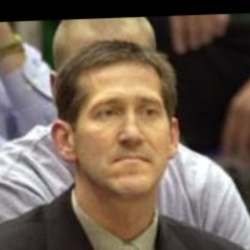

2024-05-12 16:02:12.781 | INFO     | __main__:see_images:8 - Result #2: data/photos/Gro_Harlem_Brundtland/Gro_Harlem_Brundtland_0002 was diagnosed with 91.43096 confidence
2024-05-12 16:02:12.782 | INFO     | __main__:see_images:9 - This image score was 0.9143096


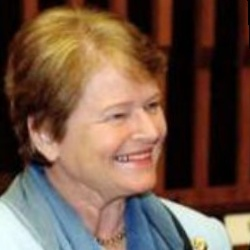

2024-05-12 16:02:12.790 | INFO     | __main__:see_images:8 - Result #3: data/photos/Jose_Alencar/Jose_Alencar_0001 was diagnosed with 91.04831 confidence
2024-05-12 16:02:12.791 | INFO     | __main__:see_images:9 - This image score was 0.9104831


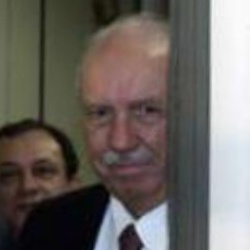

2024-05-12 16:02:12.798 | INFO     | __main__:see_images:8 - Result #4: data/photos/Jeong_Se-hyun/Jeong_Se-hyun_0004 was diagnosed with 90.86926 confidence
2024-05-12 16:02:12.798 | INFO     | __main__:see_images:9 - This image score was 0.9086926


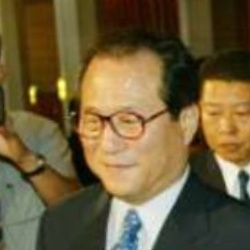

2024-05-12 16:02:12.807 | INFO     | __main__:see_images:8 - Result #5: data/photos/Dragan_Covic/Dragan_Covic_0001 was diagnosed with 90.73178 confidence
2024-05-12 16:02:12.807 | INFO     | __main__:see_images:9 - This image score was 0.9073178


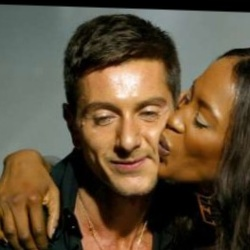

In [12]:
img = Image.open(images[0])
inputs = processor(images=img, return_tensors="pt").to(device)
one_embedding = model(**inputs).last_hidden_state
#
results = client.search(
    collection_name=my_collection,
    query_vector=one_embedding.mean(dim=1)[0].tolist(),
    limit=5,
    with_payload=True
)
see_images(results, top_k=5)